In [106]:
import os
import re
import json
import bisect
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [147]:
DATA_DIR_RAW = '/Users/chenkx/Desktop/TBIC-not_synced/Negation/data/2010_relations_challenge'
DATA_DIR = r'/Users/chenkx/Box Sync/NLP group/2010 i2b2 challenge - rel'
MAP_DIR = "/Users/chenkx/Desktop/TBIC-not_synced/Negation/notebooks/2010Corpus/section_mapping_v4_all.csv"

In [152]:
with open(MAP_DIR, 'r') as f:
    section_map = f.read()
section_map = section_map.split('\n')[1:]
section_map = {i.split(',')[0]:i.split(',')[1] for i in section_map}

In [54]:
MAP_DIR1 = "/Users/chenkx/Desktop/TBIC-not_synced/Negation/data/simple_header_map.json"
MAP_DIR2 = "/Users/chenkx/Desktop/TBIC-not_synced/Sectionizer/data/section_mapping/sectionTypeMapping.json"
with open(MAP_DIR1, 'r') as f:
    section_map1 = json.load(f)
with open(MAP_DIR2, 'r') as f:
    section_map2_tmp = json.load(f)
section_map2 = {}
# reformat section_map2 to lower case
for i in section_map2_tmp:
    section_map2[i.lower()] = section_map2_tmp[i].lower()
del section_map2_tmp

In [55]:
len(section_map)

1038

In [199]:
def header_pattern(txt):
    """
    Return an iterator yielding match objects over all non-overlapping matches
    """
    return re.finditer('(?<=\n)[a-zA-Z -]+(?=[ ]:[\n| ])', txt) # wrong and previously used: (\n[a-zA-Z -]+)(( :\n)|( : )) #TODO: ADD PARENTHESIS HERE 

In [87]:
def std_header(phrase):
    """
    standardize heading from regex matches.
        1. converting to lower case
        2. trim white space.
    If mapped them to "?": consider them as non-headers 
    """        
    phrase0 = re.sub(" :$", "", phrase.strip().lower())
    phrase = None
    if phrase0 in section_map1:
        phrase = section_map1[phrase0]
    elif phrase0 in section_map2:
        phrase = section_map2[phrase0]
    if not phrase:
        phrase = phrase0
    if phrase in section_map:
        phrase = section_map[phrase]
    else:
        print(f'Not mapped: {phrase0}')
        return None
        
    if phrase == '?':
        return None

    if phrase == '':
        return None
    
    if phrase == "Subsection" or phrase == "Date/Time" or phrase == "Providers":
        return None
    
    return phrase

In [8]:
class Reader:
    def __init__(self, path, fname):
        """
        :param path - Path to the folder of which subfolders include "txt" and "ref"
        """

        self._path = path
        self.fname = fname
        
        self.ann = {}
        self._ann_raw = []
        self.all_headings = []
        
        with open(os.path.join(self._path, "txt", self.fname+".txt"), 'r') as f:
            self.txt = f.read()
        
    def get_all_headings(self):
        matches = header_pattern(self.txt)
        for m in matches:
            match = std_header(m.group(0))
            if match:
                b, e = m.span()
                self.all_headings.append( (match, b, e) )
#         self.all_headings = [std_header(match) for i, match in enumerate([re.search('[a-zA-Z ]+(( :$)|( : ))', txt) for txt in self.txt.split('\n')])]
    
    def get_annotation(self, must_have_assertion=True):
        """
        {
            fname: {
                iterm_id: {
                    b: int begin_offset, 
                    e: int end_offset, 
                    t: str "type",
                    a: str "assertion", 
                    c: str "concept_raw_text", 
                    s: str "section"
                }
                length: int length of the note 
            }
        }

        """
        fname = self.fname
        with open(os.path.join(self._path, "ref", fname+".ann"), 'r') as f:
            ann_raw = f.read().split('\n')
            self._ann_raw = ann_raw
        
        annotations = {}
        for line in ann_raw:
            line = line.split('\t')
            if line[0].startswith('T'):
                annotations[line[0]] = {
                    'b': int(line[1].split()[1]),  
                    'e': int(line[1].split()[2]), 
                    't': line[1].split()[0], 
                    'a': None, 
                    'c': line[2], 
                    's': None
                }
        for line in ann_raw:
            line = line.split('\t')
            if line[0].startswith('A'):
                if line[1].split()[1] not in annotations:
                    print(f"Warning: {line[0]} ??")
                annotations[line[1].split()[1]]['a'] = line[1].split()[0]
                
        # remove annotations that don't have assertion informaiton 
        if must_have_assertion:
            delete = []
            for i in annotations:
                if annotations[i]['a'] is None:
                    delete.append(i)
            for i in delete:
                del annotations[i]
        
        annotations['length'] = len(self.txt)
        
        self.ann = {fname: annotations}    

Train set

In [13]:
filenames_train = [i[:-4] for i in os.listdir(os.path.join(\
    DATA_DIR, "train", "txt")) \
     if i.endswith(".txt")]
filenames_test = [i[:-4] for i in os.listdir(os.path.join(\
    DATA_DIR, "test", "txt")) \
     if i.endswith(".txt")]

In [111]:
reader.txt[868:893]

'\nPAST MEDICAL HISTORY :\n1'

### Check headings that cannot be normalized

### Pareto chart of section types
Find the top n section types that make up 80% of occurrences.

In [201]:
FILE_SORTER= r"/Users/chenkx/Box Sync/NLP group/2019 n2c2 Challenge/Track 3 (normalization)/Test/test_file_list.txt"
with open(FILE_SORTER, 'r') as f:
    sorter = f.read().split('\n')
sorter = [i for i in sorter if i != ""]

In [203]:
all_headings = []
for file in sorter:
    try:
        reader = Reader(os.path.join(DATA_DIR, "train"), file)
    except FileNotFoundError:
        reader = Reader(os.path.join(DATA_DIR, "test"), file)
    reader.get_all_headings()
    all_headings.extend([i[0] for i in reader.all_headings])

Not mapped: number of doses required ( approximate )
Not mapped: walking as tolerated follow up appointment ( s )
Not mapped: follow up appointment ( s )
Not mapped: follow up appointment ( s )
Not mapped: follow up appointment ( s )


In [11]:
print(f'Number of unique normalized sections: {len(set(all_headings))}')

Number of unique normalized sections: 33


In [12]:
# Save to disk 
# with open('header_map.json', 'w') as f:
#     for i in sorted(list(set(all_headings))):
#         f.writelines(i + '::' + i + '\n')    

In [13]:
# count the occurances of each section type
heading_count = {}
for i in all_headings:
    if not i:
        continue
    if i not in heading_count:
        heading_count[i] = 0
    heading_count[i] +=1

In [14]:
print(f'Unclassified: {(heading_count["?"] + heading_count["Unknown/Unclassified"])/sum(heading_count.values())}')

Unclassified: 0.2242190124286194


In [15]:
del heading_count['?']
del heading_count['Unknown/Unclassified']
print('Unclassified headings deleted.')

Unclassified headings deleted.


In [16]:
# remove types that only occur once. Prepare data for plotting
data = sorted(list(heading_count.items()), key=lambda x: -x[1])
# for i, e in enumerate(data):
#     if e[1] == 1:
#         idx = i
#         break
# data = data[:idx]
section = [x for x, y in data]
cnt = [y for x, y in data]
cumsum = [0]
for i in cnt:
    cumsum.append(cumsum[-1]+i)
cumsum.pop(0)

0

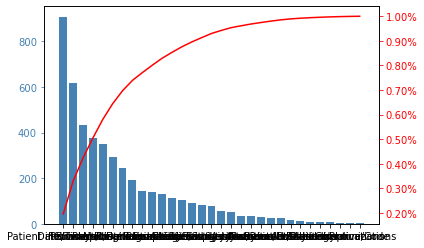

In [17]:
from matplotlib.ticker import PercentFormatter

#define aesthetics for plot
color1 = 'steelblue'
color2 = 'red'
line_size = 4

#create basic bar plot
fig, ax = plt.subplots()
ax.bar(section, cnt, color=color1)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(section, [i/sum(cnt) for i in cumsum], color=color2, ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

#display Pareto chart
plt.show()

In [18]:
common_sections = section
len(common_sections)

31

### Manual inspection of heading extraction and normalization

### Visualization of negation status by section

...

In [178]:
all_annot = {}
which_set = "train" # changed to test at some point
for i, file in enumerate(filenames_train + filenames_test):
    if i == len(filenames_train):
        which_set = "test"
    reader = Reader(os.path.join(DATA_DIR, which_set), file)
    reader.get_annotation()
    if not reader.ann:
        print(f'{file} does not contain assertion annotations')
        continue
    all_annot = {**all_annot, **reader.ann}

In [179]:
for f in all_annot:
    try:
        reader = Reader(os.path.join(DATA_DIR, "train"), f)
    except FileNotFoundError:
        reader = Reader(os.path.join(DATA_DIR, "test"), f)
    reader.get_all_headings()
    h_left = [i[1] for i in reader.all_headings]
    for i in all_annot[f]:
        if i == 'length':
            continue
        annotation = all_annot[f][i]

        s_i = bisect.bisect_left(h_left, all_annot[f][i]['b']) - 1 
        if s_i == -1:
            section = 'Unknown/Unclassified'
        else:
            section = [i[0] for i in reader.all_headings][s_i]
        all_annot[f][i]['s'] = section

Not mapped: - ct scan reading by radiologist
Not mapped: - check echo
Not mapped: - resumed coumadin as her home dose
Not mapped: - check stool occult
Not mapped: - ct scan reading by radiologist
Not mapped: - check echo
Not mapped: - resumed coumadin as her home dose
Not mapped: - check stool occult
Not mapped: - check echo
Not mapped: - resumed coumadin as her home dose
Not mapped: - check stool occult
Not mapped: - ct scan reading by radiologist
Not mapped: - check echo
Not mapped: - resumed coumadin as her home dose
Not mapped: - check stool occult
Not mapped: - check echo
Not mapped: - check stool occult
Not mapped: - check echo
Not mapped: - check stool occult
Not mapped: - check echo
Not mapped: - check stool occult
Not mapped: - check echo
Not mapped: - check stool occult


### Statistics
- The number of extracted headings using pattern `(\n[a-zA-Z -]+)(( :\n)|( : ))`: 
- The number of unique headings (all in lower case and trimmed): 

- Map them to the ontology. 
    - The total number of headings after removing non-header phrases:
    - The number of unclassified headings:    
    - Note that all unclassified headings only have one occurrance. ??
    > The percentage of classified headings:
    
    - The number of unique headings: 
    - After normalization, the number of section types: 
    > The percentage of normalized section types: 
    
    
    
    
    
    
    

In [157]:
ori_headings = []
norm_headings = []
non_normalized = set()
non_norm_cnt = 0

which_set = "train" # changed to test at some point
for i, file in enumerate(filenames_train + filenames_test):
    if i == len(filenames_train):
        which_set = "test"
    reader = Reader(os.path.join(DATA_DIR, which_set), file)
    matches = header_pattern(reader.txt)
    for m in matches:
        match = std_header(m.group(0))
        phrase0 = re.sub(" :$", "", m.group(0).strip().lower())
        if match:
            norm_headings.append(match)
            if match == '?' or match == 'Unknown/Unclassified':
                non_norm_cnt += 1
#                 if phrase0 in non_normalized:
#                     print(f'"{phrase0}" cannot be normalized. And it has occurred at least once.' )
                non_normalized.add(phrase0)
        ori_headings.append(phrase0)


Not mapped: - ct scan reading by radiologist
Not mapped: - check echo
Not mapped: - resumed coumadin as her home dose
Not mapped: - check stool occult
Not mapped: - ct scan reading by radiologist
Not mapped: - check echo
Not mapped: - resumed coumadin as her home dose
Not mapped: - check stool occult
Not mapped: - check echo
Not mapped: - resumed coumadin as her home dose
Not mapped: - check stool occult
Not mapped: - ct scan reading by radiologist
Not mapped: - check echo
Not mapped: - resumed coumadin as her home dose
Not mapped: - check stool occult
Not mapped: - check echo
Not mapped: - check stool occult
Not mapped: - check echo
Not mapped: - check stool occult
Not mapped: - check echo
Not mapped: - check stool occult
Not mapped: - check echo
Not mapped: - check stool occult


In [158]:
unclassified_cnt = sum([i=='?' or i == 'Unknown/Unclassified' for i in norm_headings])

print(f"""
- The number of extracted headings using the pattern: {len(ori_headings)}
- The number of unique extractions (all in lower case and trimmed): {len(set(ori_headings))}

- Map them to the ontology. 
    - The total number of headings after removing non-header phrases: {len(norm_headings)}
    - The number of headings that cannot be normalized: {unclassified_cnt}   
    - Note that all such headings only have one occurrance. ?? (FALSE STATEMENT)
    --> The percentage of normalized headings: {int(100 - 100*unclassified_cnt/len(norm_headings))}%
    
    - After normalization, the number of section types: {len(set(norm_headings))}
    --> The percentage of normalized section types: ??

""")


- The number of extracted headings using the pattern: 15146
- The number of unique extractions (all in lower case and trimmed): 1229

- Map them to the ontology. 
    - The total number of headings after removing non-header phrases: 6915
    - The number of headings that cannot be normalized: 0   
    - Note that all such headings only have one occurrance. ?? (FALSE STATEMENT)
    --> The percentage of normalized headings: 100%
    
    - After normalization, the number of section types: 30
    --> The percentage of normalized section types: ??




## Concepts that have an assertion status

#### Percentage of the 6 assertion types  in each section 

In [180]:
df = pd.DataFrame(columns=['b', 'e', 't', 'a', 'c', 's'])
for f in all_annot:
    for i in all_annot[f]:
        if i == 'length':
            continue
        tmp =pd.DataFrame(all_annot[f][i], index=['::'.join([f, i])])
        df = pd.concat([df, tmp], ignore_index=False)

In [181]:
df

,b,e,t,a,c,s
284487129::T1,180,215,problem,present,insulin dependent diabetes mellitus,Problems
284487129::T2,236,266,problem,present,anterior myocardial infarction,Problems
284487129::T3,281,296,problem,present,pulmonary edema,Problems
284487129::T4,300,320,problem,present,hypercholesterolemia,Problems
284487129::T5,391,427,problem,present,prior anterior myocardial infarction,Chief complaint
...,...,...,...,...,...,...
0354::T20,1031,1064,problem,present,a massive subarachnoid hemorrhage,Medications
0354::T21,1070,1104,problem,present,bleeding in the subarachnoid space,Medications
0354::T22,1152,1177,problem,present,significant hydrocephalus,Medications
0354::T24,1218,1235,problem,present,her hydrocephalus,Medications


array([False, False, False, ..., False, False, False])

In [188]:
df1 = df[~df.index.str.contains('progress')]
df1

,b,e,t,a,c,s
284487129::T1,180,215,problem,present,insulin dependent diabetes mellitus,Problems
284487129::T2,236,266,problem,present,anterior myocardial infarction,Problems
284487129::T3,281,296,problem,present,pulmonary edema,Problems
284487129::T4,300,320,problem,present,hypercholesterolemia,Problems
284487129::T5,391,427,problem,present,prior anterior myocardial infarction,Chief complaint
...,...,...,...,...,...,...
0354::T20,1031,1064,problem,present,a massive subarachnoid hemorrhage,Medications
0354::T21,1070,1104,problem,present,bleeding in the subarachnoid space,Medications
0354::T22,1152,1177,problem,present,significant hydrocephalus,Medications
0354::T24,1218,1235,problem,present,her hydrocephalus,Medications


In [189]:
# save to csv 
df1.to_csv("explore_i2b2-2010-v5.0-problem_concepts.csv", index_label="id")

In [44]:
# print("Percentage of 'Problems' that do not have a valid section type:")
# try: 
#     print((df['s'].value_counts()['Unknown/Unclassified'] + df['s'].value_counts()['?'])/sum(df['s'].value_counts()))
# except KeyError:
#     print(df['s'].value_counts()['?']/sum(df['s'].value_counts()))

In [162]:
df['s'].value_counts()

Hospital course                     7012
Present illness                     4163
Physical examination/Status         3540
Past history                        2982
Diagnoses                           2390
Patient information/Demographics    1905
Medications                         1034
Investigations/Results               965
Follow-up/Instructions               935
Assessment/Plan                      889
Laboratory tests                     833
Assessment                           679
Problems                             411
Unknown/Unclassified                 409
Reasons/Indications                  342
Allergies                            326
Radiology                            285
Procedures/Surgery                   269
Chief complaint                      208
Family history                       194
Review of systems                    191
Nutrition                            174
Addendum                             134
Consultations                         74
Social history  

In [62]:
df['s'].value_counts()

Hospital course                     6959
Present illness                     4016
Subsection                          3444
Diagnoses                           2325
Past history                        2236
Physical examination/Status         1904
Date/Time                           1329
Investigations/Results               974
Medications                          964
Follow-up/Instructions               908
Laboratory tests                     825
Assessment/Plan                      616
Radiology                            461
Assessment                           428
Problems                             415
Providers                            372
Unknown/Unclassified                 345
Reasons/Indications                  334
Allergies                            278
Procedures/Surgery                   264
Chief complaint                      209
Review of systems                    191
Family history                       186
Patient information/Demographics     150
Addendum        

In [244]:
df = df[(df['s']!='?') & (df['s']!='Unknown/Unclassified')]
print('Invalid sections removed')

Invalid sections removed


In [245]:
plotdf = None
for i, sec in enumerate(df['s'].value_counts().index):
#     if i ==  15:
#         break
    s = df[df['s']==sec]['a'].value_counts()
    if plotdf is None:
        plotdf = s.rename(sec)
    else:
        plotdf = pd.concat([plotdf, s.rename(sec)], axis=1)


In [246]:
plotdf = plotdf.fillna(0)

In [253]:
# plotdf.to_csv('results.csv')

In [169]:
import plotly.graph_objects as go
import plotly.offline as phy

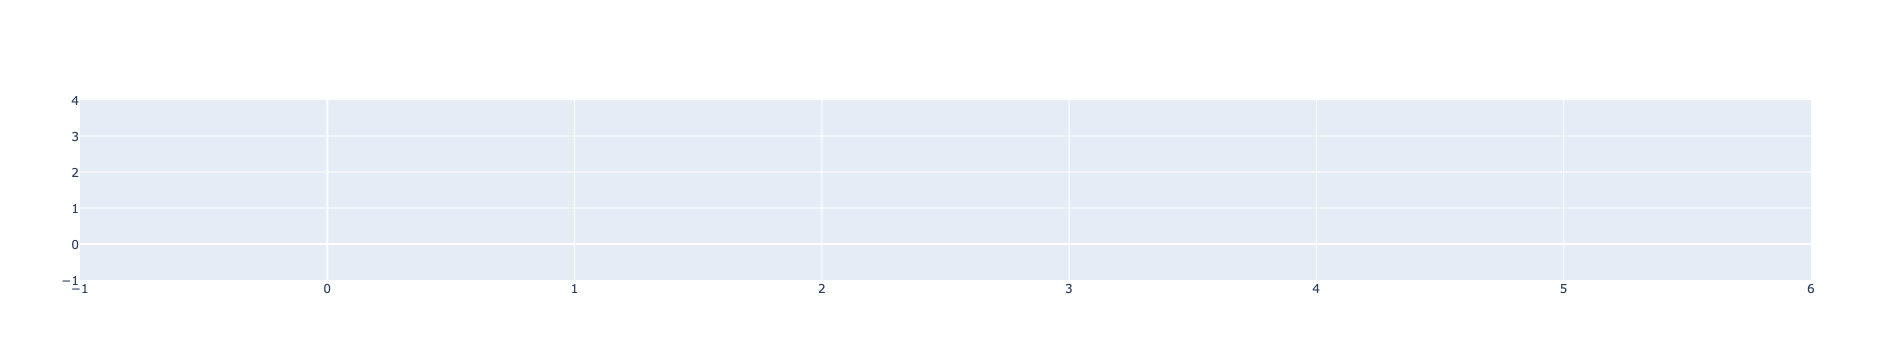

In [170]:
fig = go.Figure()
fig.update_polars(radialaxis=dict(range=[0, 1]))
# categories = ['present', 'absent', 'associated_with_someone_else', \
#               'hypothetical', 'possible', 'conditional']
# fig.add_trace(go.Scatterpolar(
#     r=[0]*5,
#     theta=categories, 
#     fill='toself', 
#     name=''
# ))

Hospital course (n=2486)


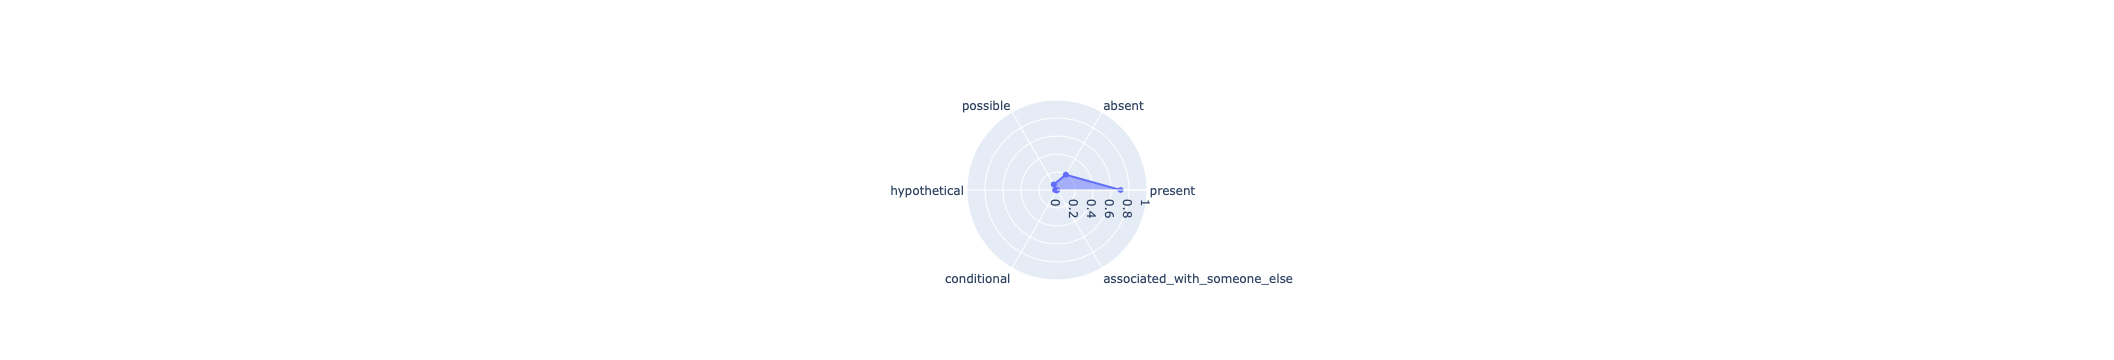

Present illness (n=1414)


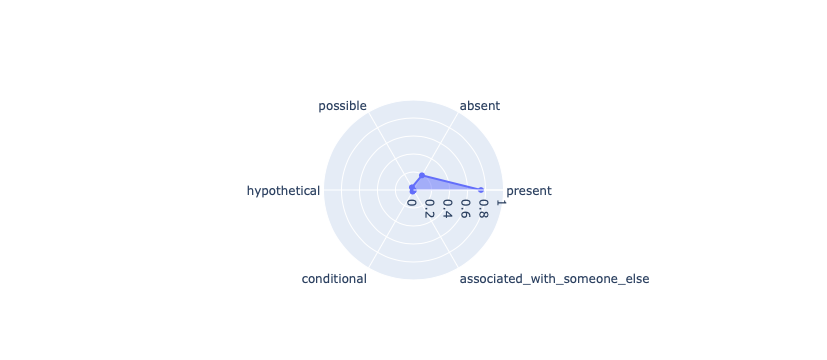

Diagnoses (n=989.0)


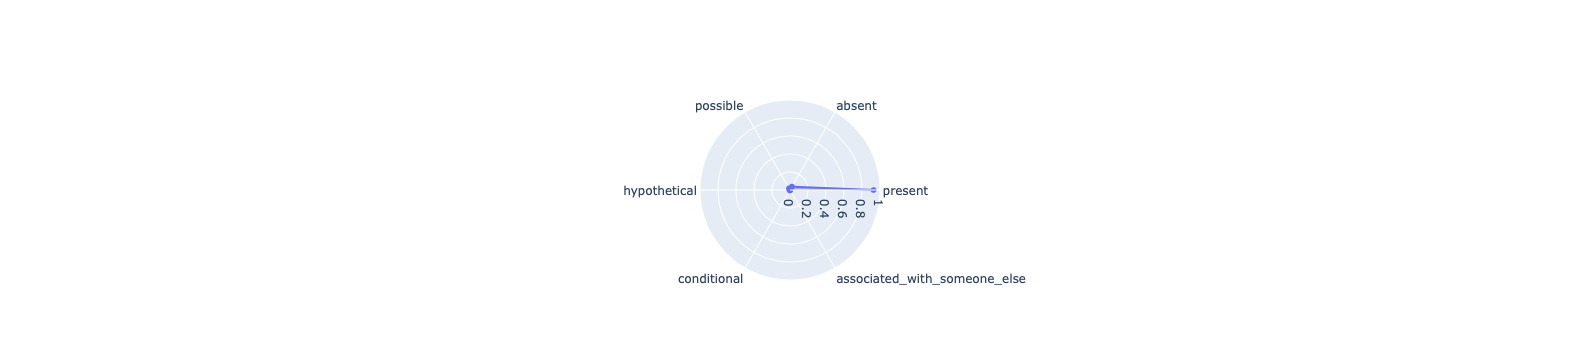

Subsection (n=952.0)


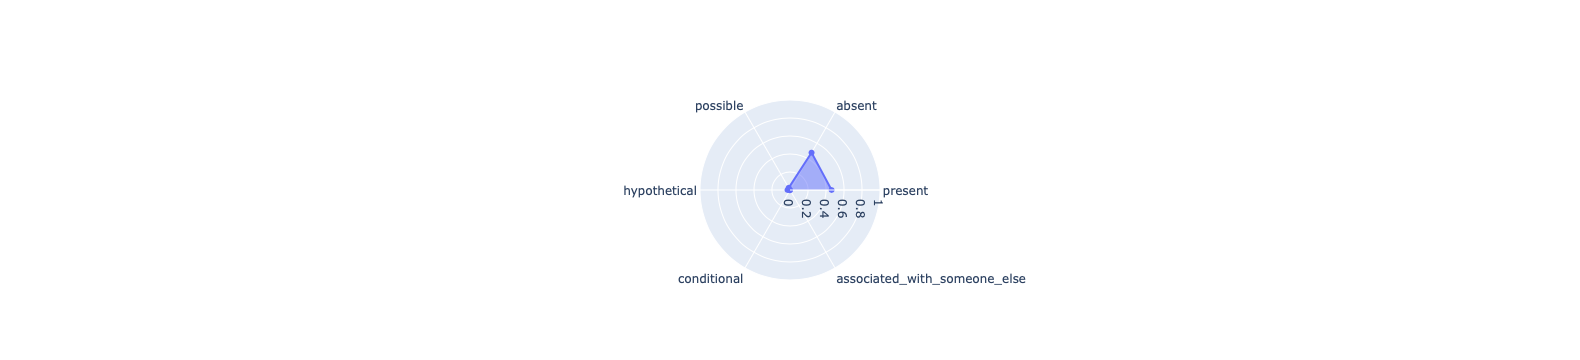

Past history (n=656.0)


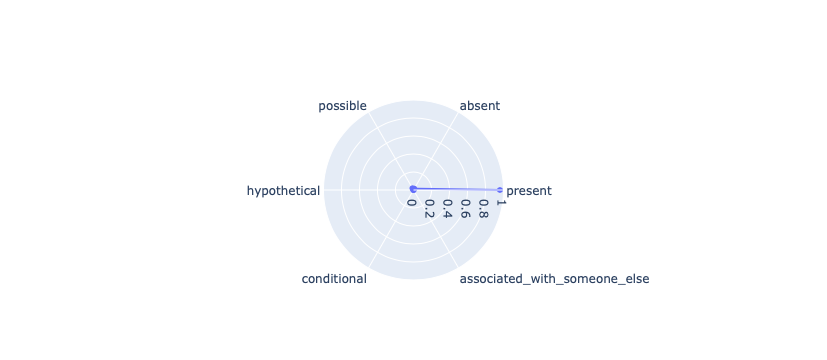

Physical examination/Status (n=636.0)


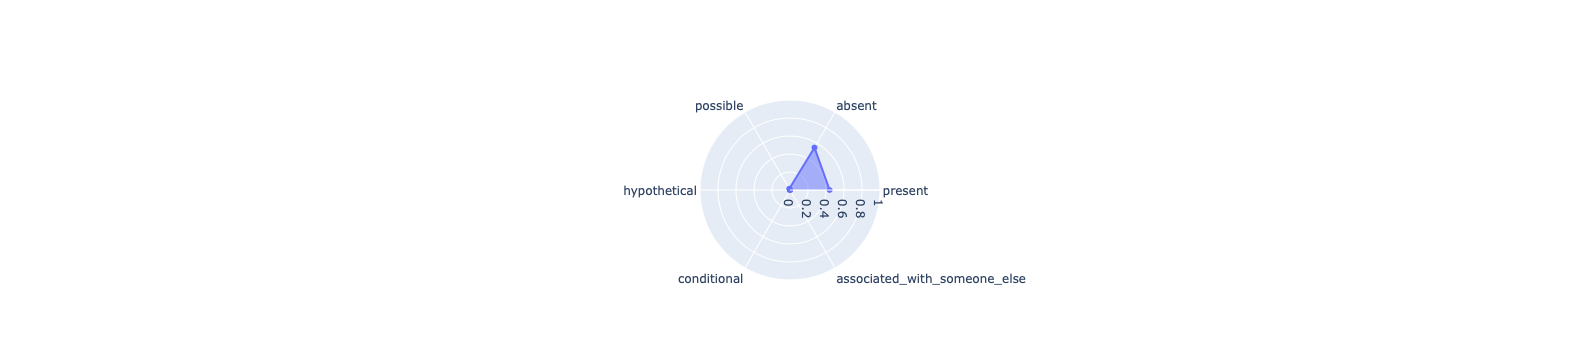

Follow-up/Instructions (n=450.0)


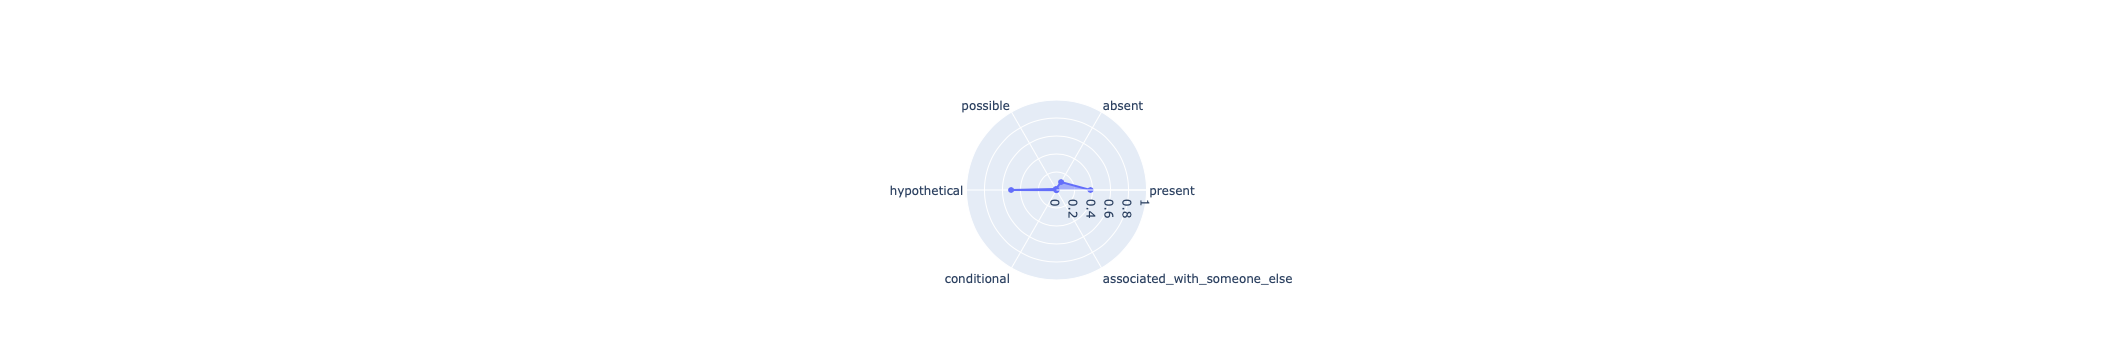

Date/Time (n=402.0)


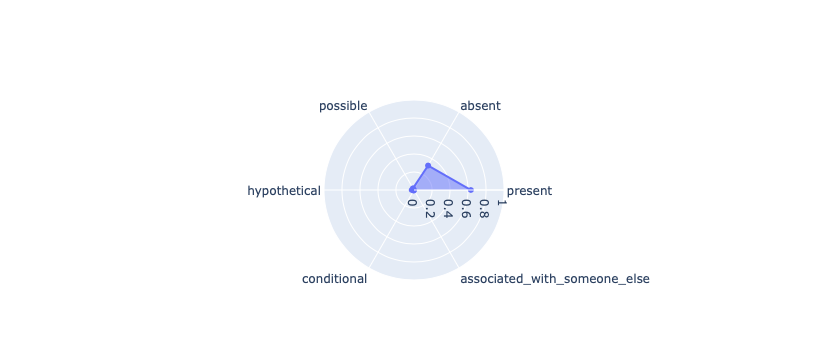

Medications (n=354.0)


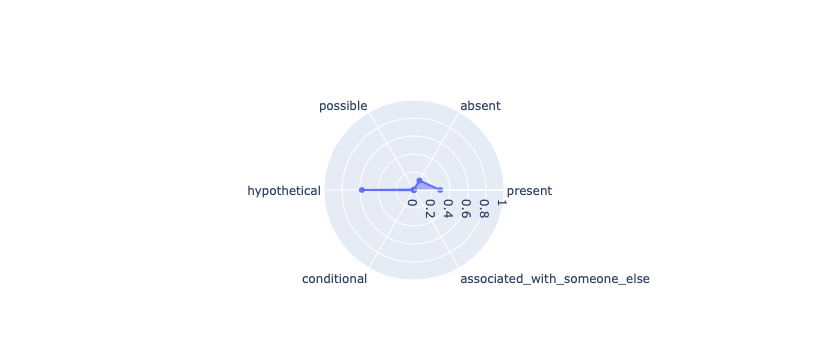

Investigations/Results (n=344.0)


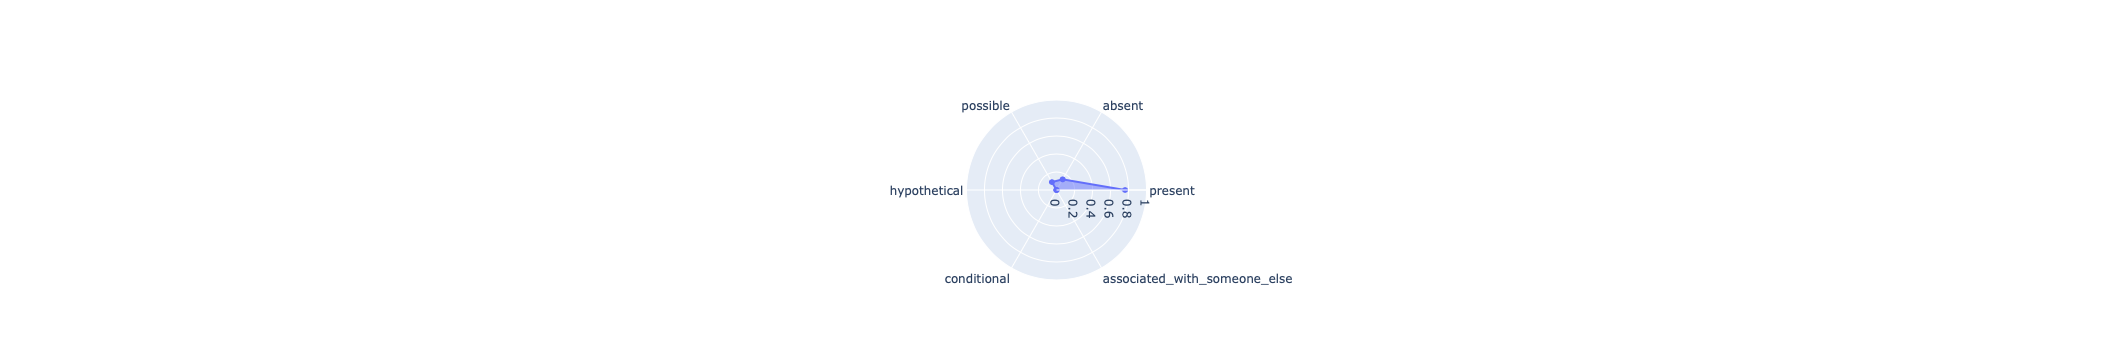

Laboratory tests (n=260.0)


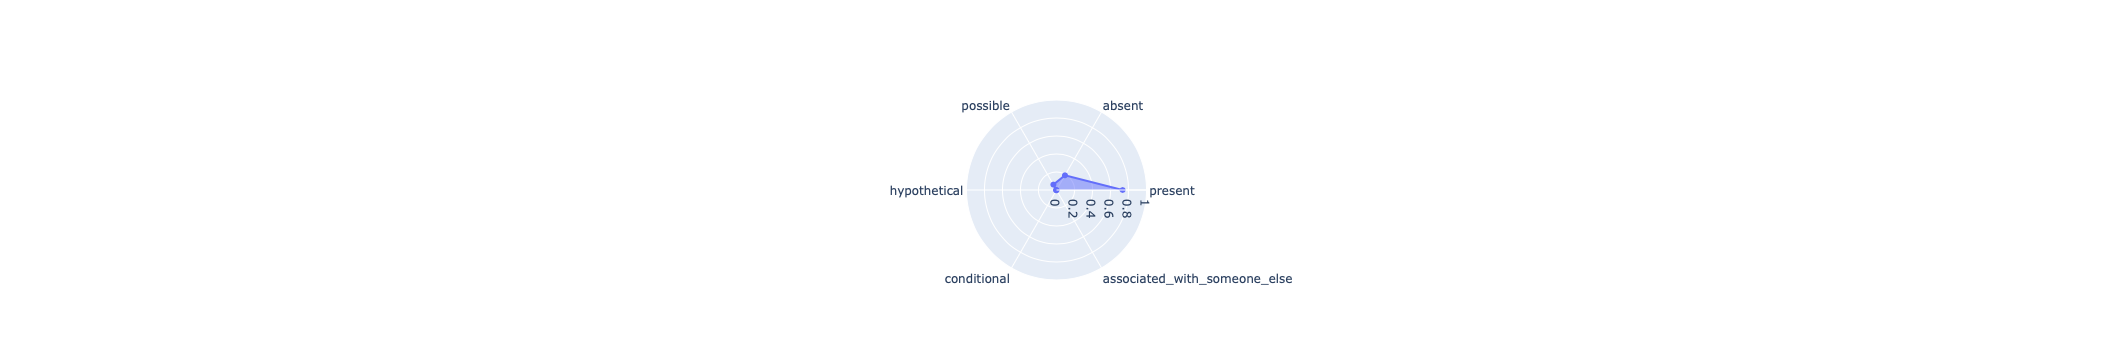

Assessment/Plan (n=252.0)


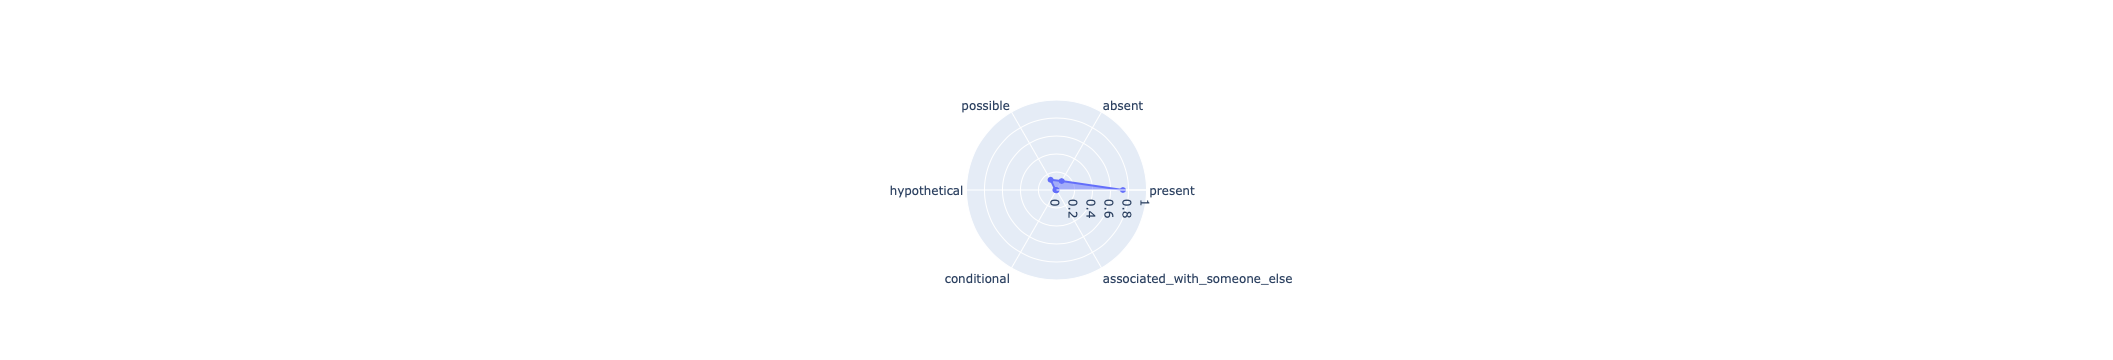

Problems (n=177.0)


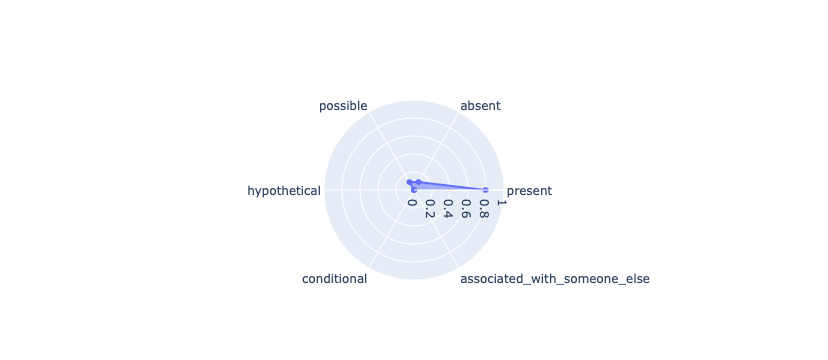

Assessment (n=166.0)


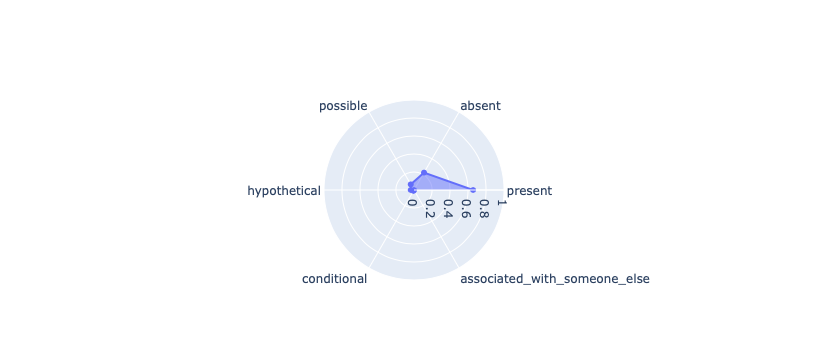

Allergies (n=160.0)


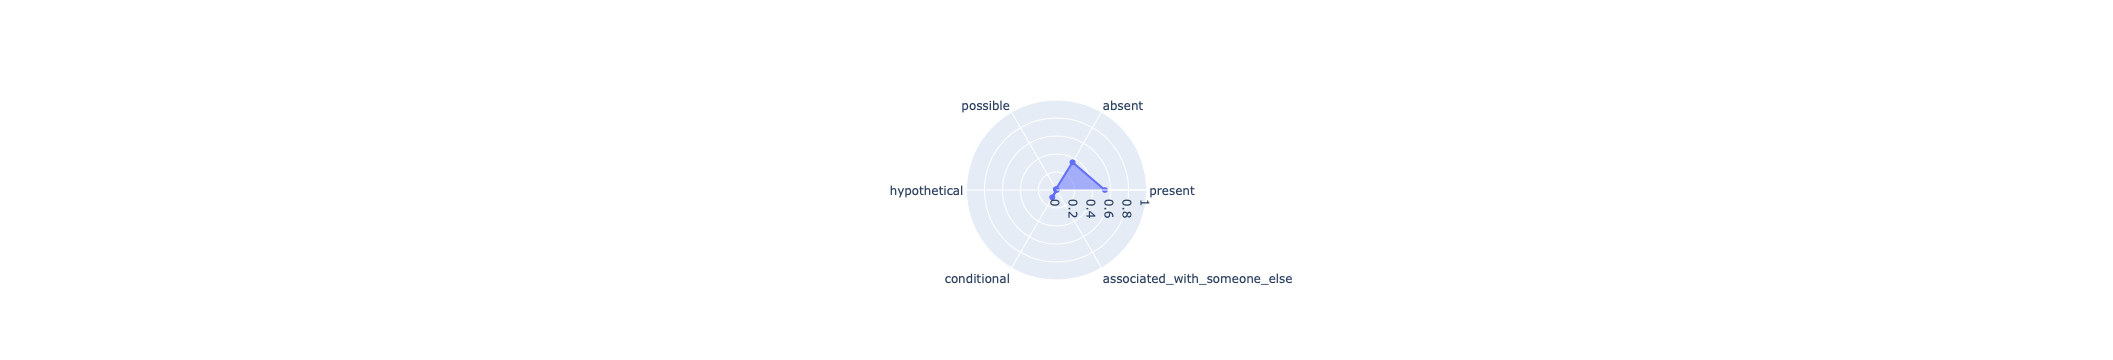

Procedures/Surgery (n=137.0)


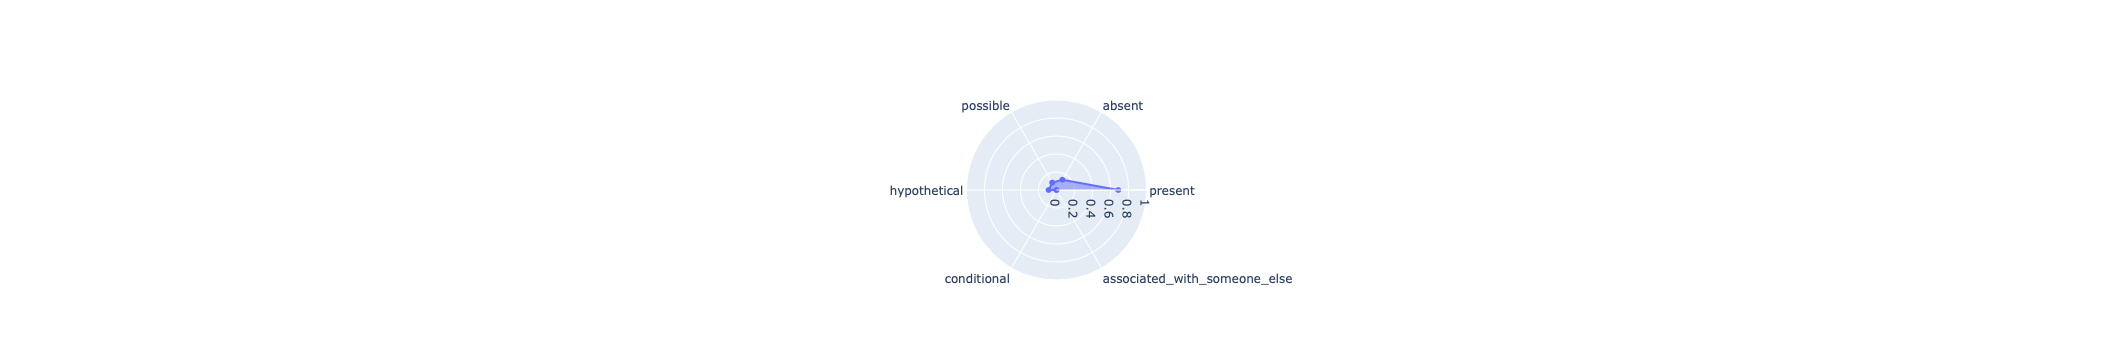

Chief complaint (n=116.0)


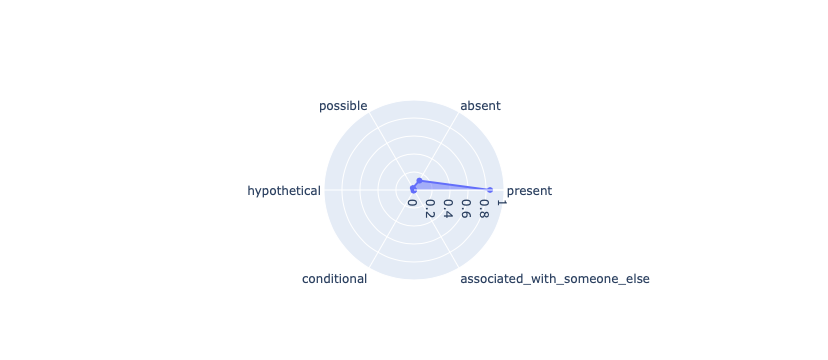

Providers (n=115.0)


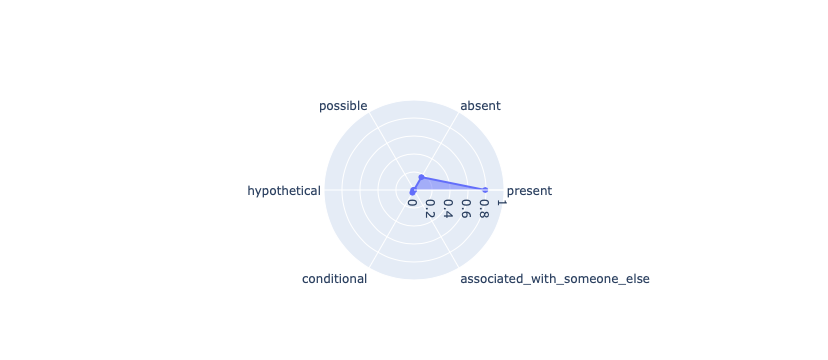

Reasons/Indications (n=109.0)


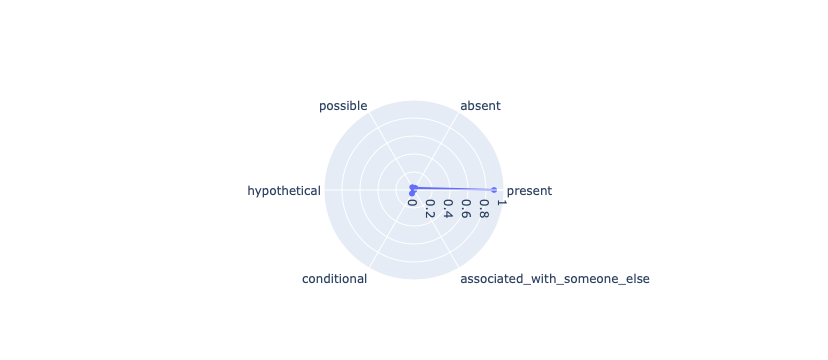

other (n=97.0)


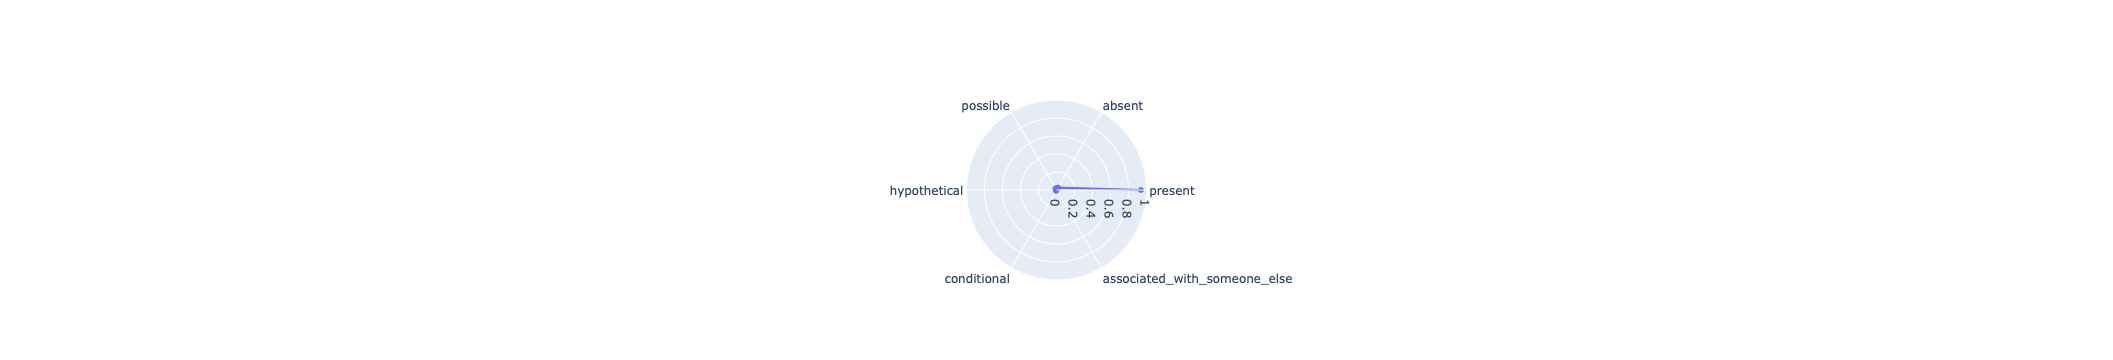

Review of systems (n=72.0)


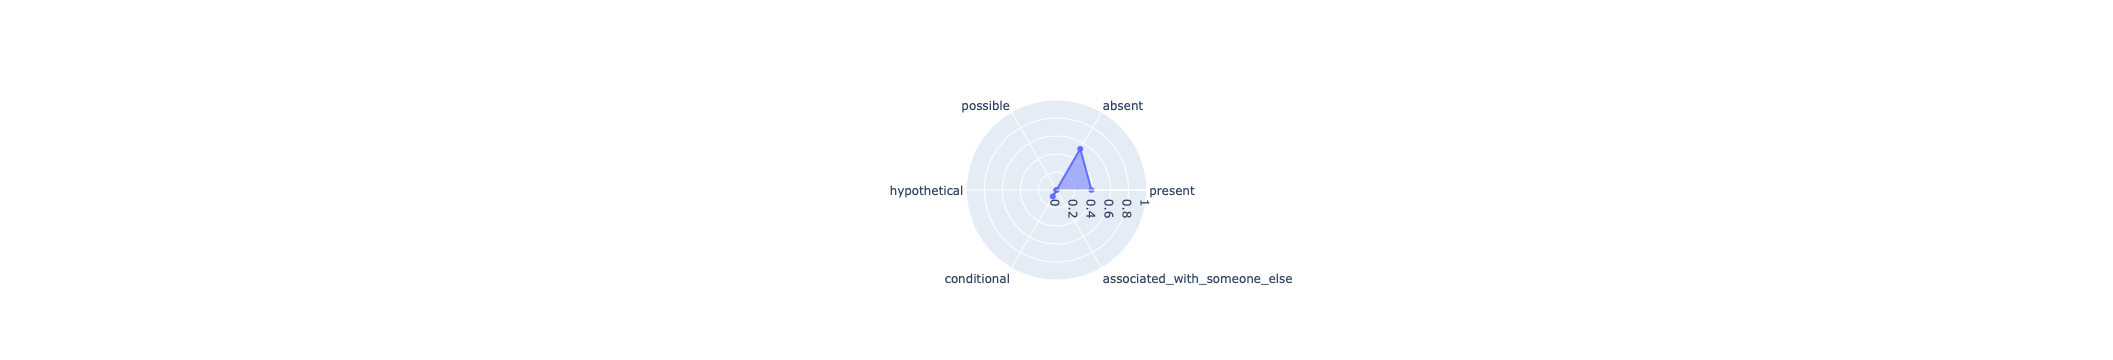

Family history (n=69.0)


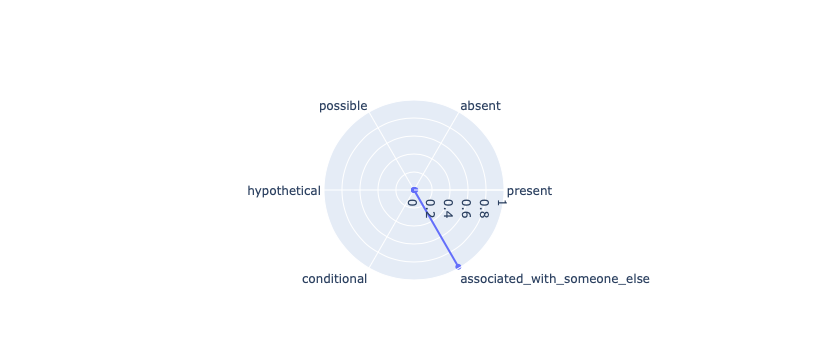

Radiology (n=56.0)


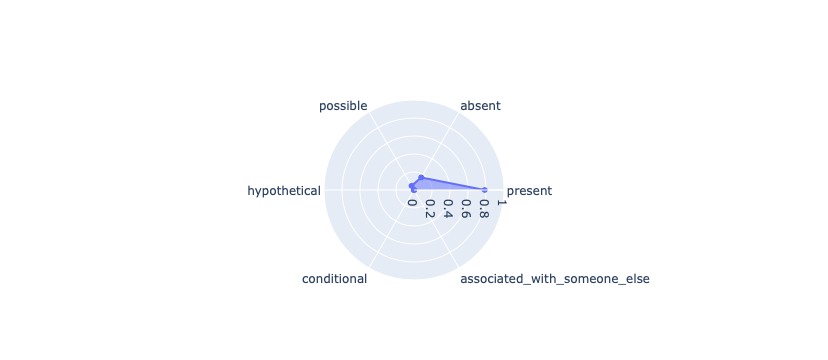

Nutrition (n=39.0)


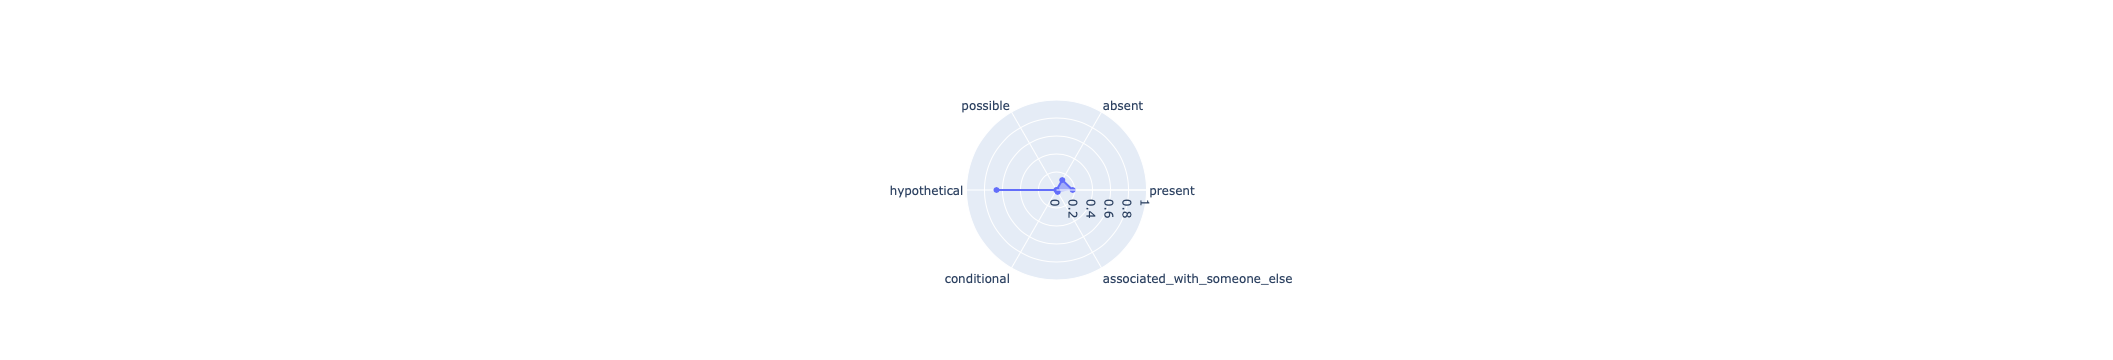

Consultations (n=28.0)


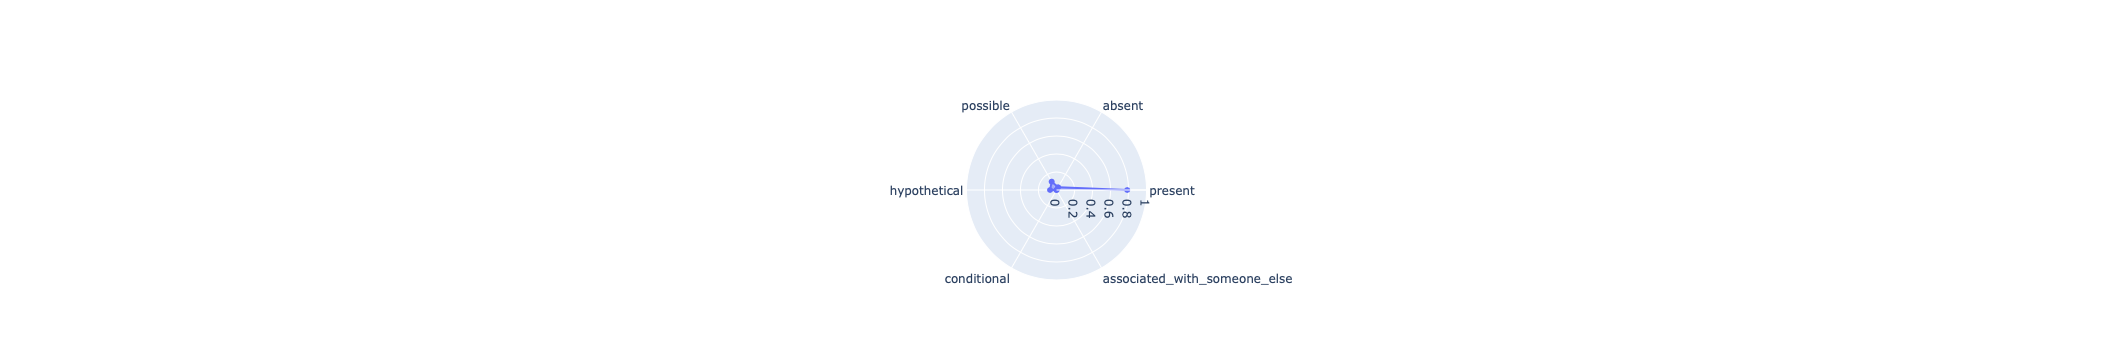

Social history (n=14.0)


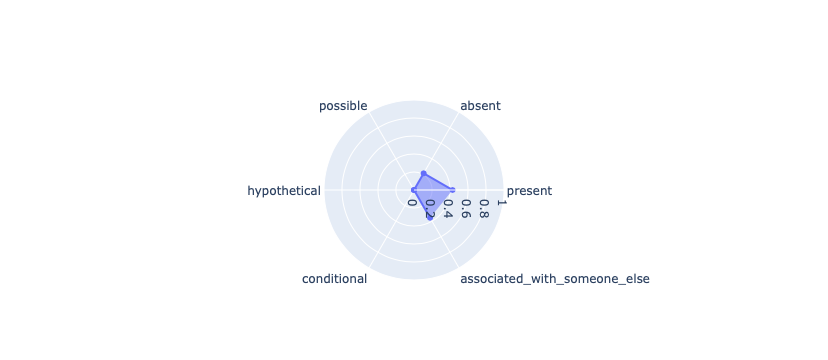

Addendum (n=11.0)


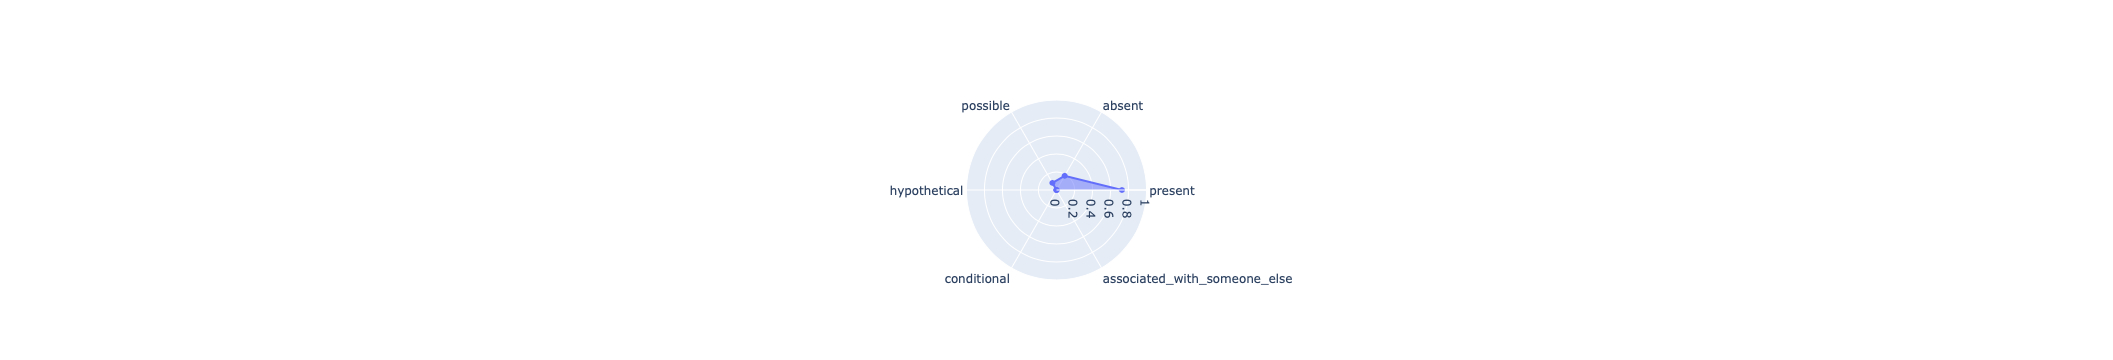

Immunizations (n=7.0)


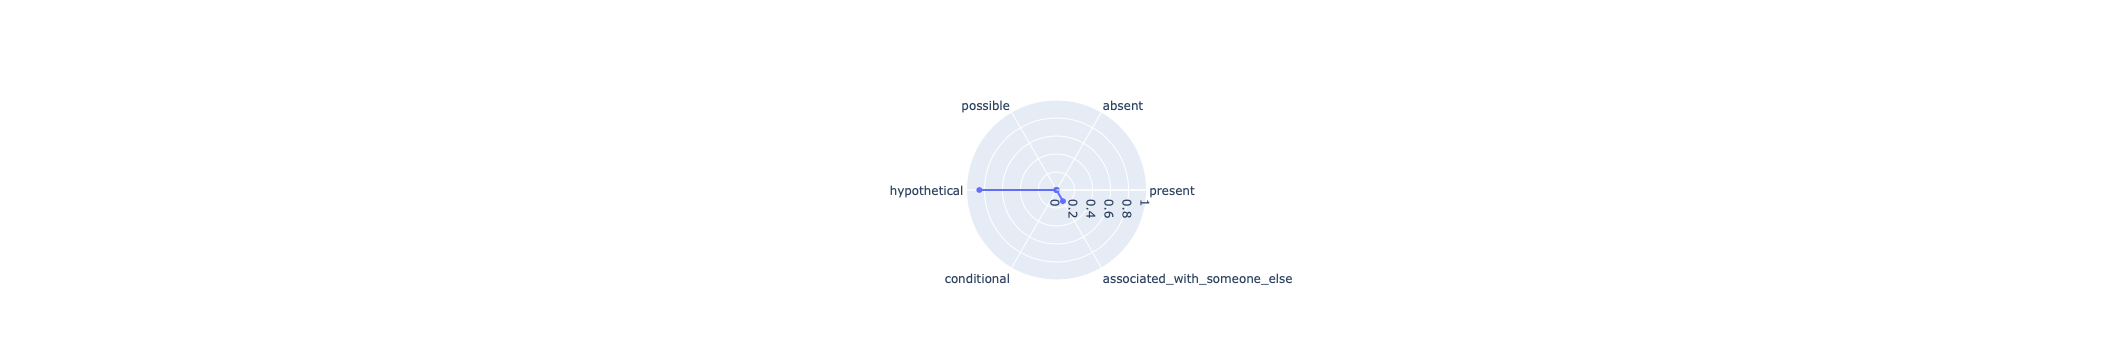

Patient information/Demographics (n=2.0)


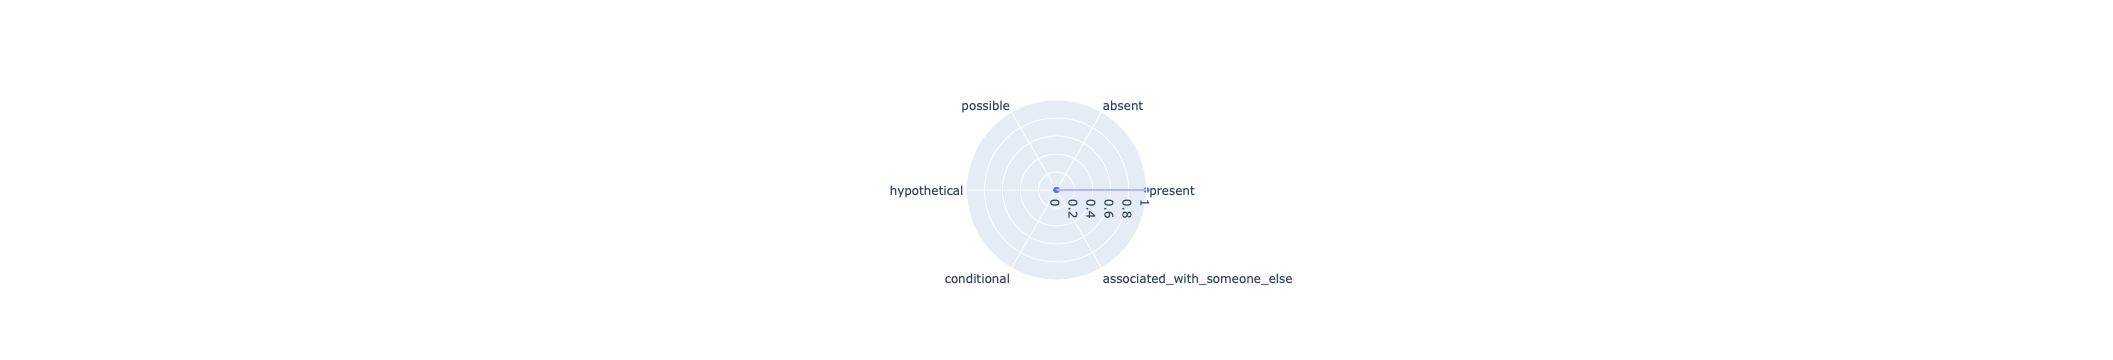

In [171]:
for i in plotdf:
    fig = go.Figure()
    fig.update_polars(radialaxis=dict(range=[0, 1]))
    fig.add_trace(go.Scatterpolar(
        r=plotdf[i]/plotdf[i].sum(),
        theta=plotdf.index, 
        fill='toself', 
        name=i
    ))
    print(f'{i} (n={plotdf[i].sum()})')
    fig.show()
# Conclusions:
    # Mostly present: Hospital course, present illness, 
    # present: Diagnoses

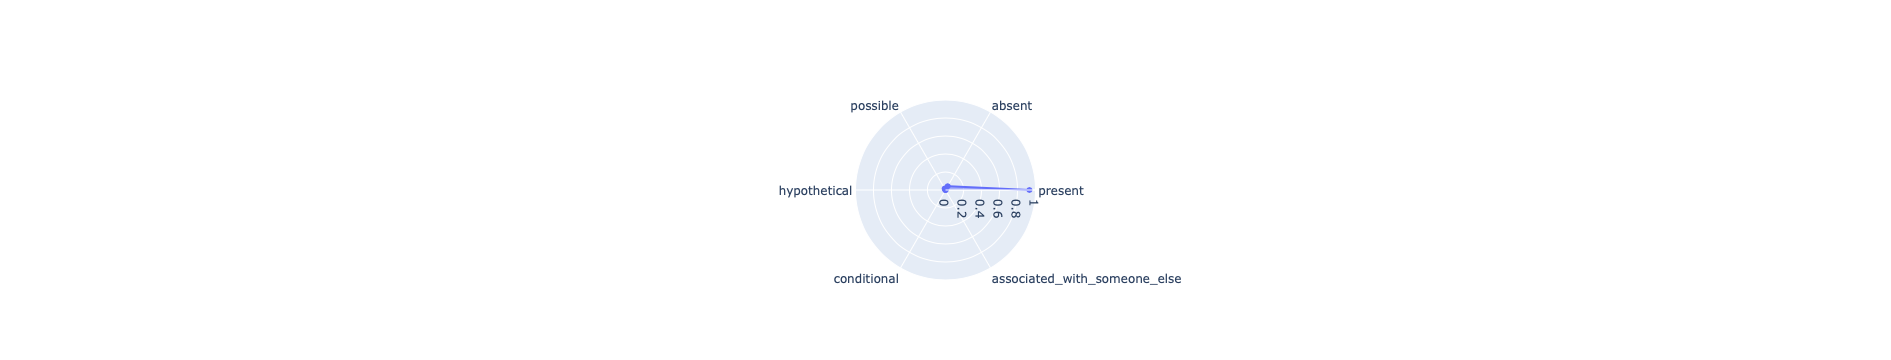

In [37]:
fig.show()

#### Distribution of Contextual Information - Location of Headings 
(Presented in the report of 20221205. Skipped here.)
Fist make sure only concepts whose type is "problem" have assertion info. 
Then show the disctribution of the 6 types of assertion.
Lastly, show the distribution of assertion by section type. Note that only a few section types are selected here. 

In [ ]:
# only concepts of "problem" have annotation of its assertion status
for f in all_annot:
    annot = all_annot[f]
    for i in annot:
        if i == 'length': 
            continue
        if annot[i]['t'] != 'problem':
            print(f'{f}: {annot[i]["c"]}')

In [ ]:
ast = []
loc = []
for f in all_annot:
    annot = all_annot[f]
    for i in annot:
        if i == 'length':
            continue
        ast.append(annot[i]['a'])
        loc.append(annot[i]['b']/annot['length'])

In [ ]:
df = pd.DataFrame({'ast': ast, 'loc': loc})

In [ ]:
# distribution of negations
import seaborn as sns
sns.displot(df, x='loc', binwidth=.01, col='ast')

In [ ]:
sections = []
for f in all_annot:
    annot = all_annot[f]
    for i in annot:
        if i == 'length':
            continue
        sections.append(annot[i]['s'])

In [ ]:
df['sections'] = sections

In [ ]:
df[:3]

In [ ]:
for s in common_sections:
    if s not in df.sections.values:
        continue
    sns.displot(df.loc[df['sections']==s], x='loc', binwidth=.01, col='ast')
    print(s)
    plt.show()

In [ ]:
for s in common_sections:
    tmp = df.loc[(df['sections']==s) & (df['ast']!= 'present')]
    if len(tmp) < 10:
        continue
    sns.displot(tmp.loc[tmp['sections']==s], x='loc', binwidth=.01, col='ast')
    print(s)
    plt.show()

In [ ]:
# hexagon 

## ALL concepts, including concepts that do not have an assertion status

In [190]:
all_annot = {}
which_set = "train" # changed to test at some point
for i, file in enumerate(filenames_train + filenames_test):
    if i == len(filenames_train):
        which_set = "test"
    reader = Reader(os.path.join(DATA_DIR, which_set), file)
    reader.get_annotation(must_have_assertion=False)
    if not reader.ann:
        print(f'{file} does not contain assertion annotations')
        continue
    all_annot = {**all_annot, **reader.ann}

In [191]:
for f in all_annot:
    try:
        reader = Reader(os.path.join(DATA_DIR, "train"), f)
    except FileNotFoundError:
        reader = Reader(os.path.join(DATA_DIR, "test"), f)
    reader.get_all_headings()
    h_left = [i[1] for i in reader.all_headings]
    for i in all_annot[f]:
        if i == 'length':
            continue
        annotation = all_annot[f][i]

        s_i = bisect.bisect_left(h_left, all_annot[f][i]['b']) - 1 
        if s_i == -1:
            section = 'Unknown/Unclassified'
        else:
            section = [i[0] for i in reader.all_headings][s_i]
        all_annot[f][i]['s'] = section

Not mapped: - ct scan reading by radiologist
Not mapped: - check echo
Not mapped: - resumed coumadin as her home dose
Not mapped: - check stool occult
Not mapped: - ct scan reading by radiologist
Not mapped: - check echo
Not mapped: - resumed coumadin as her home dose
Not mapped: - check stool occult
Not mapped: - check echo
Not mapped: - resumed coumadin as her home dose
Not mapped: - check stool occult
Not mapped: - ct scan reading by radiologist
Not mapped: - check echo
Not mapped: - resumed coumadin as her home dose
Not mapped: - check stool occult
Not mapped: - check echo
Not mapped: - check stool occult
Not mapped: - check echo
Not mapped: - check stool occult
Not mapped: - check echo
Not mapped: - check stool occult
Not mapped: - check echo
Not mapped: - check stool occult


In [192]:
'in' in 'ashinsdf'

True

#### Percentage of the 6 assertion types  in each section 

In [193]:
df = pd.DataFrame(columns=['b', 'e', 't', 'a', 'c', 's'])
for num, f in enumerate(all_annot):
    if 'progress' in f:
        continue
    print(f'{num}, {f}')
    for i in all_annot[f]:
        if i == 'length':
            continue
        tmp =pd.DataFrame(all_annot[f][i], index=['::'.join([f, i])])
        df = pd.concat([df, tmp], ignore_index=False)

0, 284487129
1, record-51
2, record-45
3, discharge95
4, discharge81
5, discharge56
6, record-107
7, record-106
8, discharge57
9, discharge80
10, discharge94
11, 959086752
12, 627258104
13, record-50
14, 134300717
15, record-46
16, record-52
17, discharge82
18, discharge96
20, 337702516_WGH
21, discharge119
22, discharge55
23, 891864133_RWH
24, discharge69
25, 262912613
26, 384729825
27, discharge68
28, record-105
29, discharge54
30, discharge118
31, discharge97
33, discharge83
34, record-84
35, 101407944_PUMC
36, record-53
37, record-47
38, 839999049_YC
39, 517414339
40, 622086964
41, record-80
42, 910458031
43, 544907529_RWH
45, discharge87
46, discharge93
47, 351853846_WGH
48, discharge78
49, discharge108
50, discharge50
51, discharge51
52, discharge109
53, discharge79
54, discharge92
55, 699905656_SC
56, discharge86
58, record-81
59, record-56
60, 843566350_RWH
61, 274230067_EH
62, 373254497_PUMC
63, 212512774_WGH
64, record-68
65, record-54
66, record-83
67, 188543380
68, discharg

In [194]:
df

,b,e,t,a,c,s
284487129::T1,180,215,problem,present,insulin dependent diabetes mellitus,Problems
284487129::T2,236,266,problem,present,anterior myocardial infarction,Problems
284487129::T3,281,296,problem,present,pulmonary edema,Problems
284487129::T4,300,320,problem,present,hypercholesterolemia,Problems
284487129::T5,391,427,problem,present,prior anterior myocardial infarction,Chief complaint
...,...,...,...,...,...,...
0354::T26,1347,1366,treatment,None,the ventriculostomy,Medications
0354::T27,1494,1506,problem,present,her diseases,Medications
0354::T28,1537,1540,treatment,None,dnr,Medications
0354::T29,1554,1558,treatment,None,care,Medications


In [195]:
df1 = df[~df.index.str.contains('progress')]
df1

,b,e,t,a,c,s
284487129::T1,180,215,problem,present,insulin dependent diabetes mellitus,Problems
284487129::T2,236,266,problem,present,anterior myocardial infarction,Problems
284487129::T3,281,296,problem,present,pulmonary edema,Problems
284487129::T4,300,320,problem,present,hypercholesterolemia,Problems
284487129::T5,391,427,problem,present,prior anterior myocardial infarction,Chief complaint
...,...,...,...,...,...,...
0354::T26,1347,1366,treatment,None,the ventriculostomy,Medications
0354::T27,1494,1506,problem,present,her diseases,Medications
0354::T28,1537,1540,treatment,None,dnr,Medications
0354::T29,1554,1558,treatment,None,care,Medications


In [196]:
# save to csv 
df1.to_csv("explore_i2b2-2010-v5.0-ALL_concepts.csv", index_label="id")

In [168]:
print("Percentage of concepts that do not have a valid section type:")
try: 
    print((df['s'].value_counts()['Unknown/Unclassified'] + df['s'].value_counts()['?'])/sum(df['s'].value_counts()))
except KeyError:
    print(df['s'].value_counts()['?']/sum(df['s'].value_counts()))

Percentage of concepts that do not have a valid section type:


KeyError: '?'

In [19]:
df['s'].value_counts()

Hospital course                     5736
?                                   3614
Medications                         2834
Present illness                     2419
Subsection                          1639
Diagnoses                           1482
Investigations/Results              1440
Laboratory tests                    1390
Physical examination/Status         1176
Follow-up/Instructions              1074
Past history                         934
Date/Time                            846
Assessment/Plan                      537
Problems                             445
Allergies                            402
Procedures/Surgery                   388
Assessment                           237
Reasons/Indications                  218
Providers                            204
Chief complaint                      153
other                                121
Family history                        98
Radiology                             90
Nutrition                             80
Review of system